# Rating Prediction with Deep Learning

## Fine Tuning NN Layers
### 1. Embedding layer: trained vs pre-trained(Google’s Word2vec, Stanford’s GloVe)
### 2. Effect of LSTM and GRU
### 3.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,LSTM,GRU,Embedding,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import plotly.express as px
from pickle import dump,load
import os
%matplotlib inline
#%matplotlib widget

In [61]:
#CONSTANTS
EMBEDDING_DIM = 3
VALIDATION_SPLIT = 0.3
SAMPLE_SIZE = 0.0001
MAX_SEQUENCE_LENGTH = 100
FILE_PATH = '../../6 - NPL files/yelp_training_set_review(with text_length and transformed)-new.csv'
GLOVE_DIR = '../../../Machine Learning documents/glove/'

In [62]:
data_file = pd.read_csv(FILE_PATH)
data_file = data_file[(data_file['stars'] == 1) | (data_file['stars'] == 5)].sample(frac=SAMPLE_SIZE).copy()
data_file = data_file[['stars', 'text_transformed']]

In [63]:
all_text = data_file['text_transformed'].values
all_text = all_text.astype('str')
tokenizer = Tokenizer()
#tokenizer = load(open('keras_lstm_tokenizer','br'))
tokenizer.fit_on_texts(all_text)
#dump(tokenizer,open('keras_lstm_tokenizer','wb'))
sequences = tokenizer.texts_to_sequences(all_text)
count_unique = len(tokenizer.word_counts)
pad_encoded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')

In [64]:
sequences_1d = []
for i in sequences:
    for j in i:
        sequences_1d.append(j)
sequences_1d = np.array(sequences_1d)
print(sequences_1d.shape,len(np.unique(sequences_1d)),len(np.unique(pad_encoded)))

(644,) 455 438


In [65]:
X = np.array(pad_encoded)
y = pd.get_dummies(data_file['stars'], drop_first=True).values
# y = to_categorical(data_file['stars'], num_classes=5)
seq_len = X.shape[1]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VALIDATION_SPLIT, random_state=42)
print(X_train.shape,X_test.shape)

(6, 100) (3, 100)


In [67]:
compare_model = {}

In [68]:
class NLP_training():
    def __init__(self, model_name, model):
        self.model = model
        self.model_name = model_name
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # print(self.model.summary())
    def fit_plot(self, X_train, y_train, X_test, y_test, verbose, plot_bar=True):
        early_stop = EarlyStopping(monitor='loss', mode='min',patience=10)
        history = self.model.fit(X_train,y_train,
                                 batch_size=128,
                                 epochs=10,
                                 verbose=verbose,
                                 validation_data=(X_test, y_test),
                                 callbacks=[early_stop]
                                 )
        #plot the results
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        print('Accuracy: %f' % (accuracy*100))
        compare_model[self.model_name] = accuracy*100
        plt.figure(figsize=(14,4))
        ax = plt.subplot(1,2,1)
        pd.DataFrame(history.history).plot(ax=ax)
        if plot_bar:
            ax = plt.subplot(1,2,2)
            pd.DataFrame(compare_model, index=['models']).plot(kind='bar', ax=ax, rot=0)
            plt.ylim([94.0,97.0])
            plt.legend(loc=(1,0.6))

In [69]:
def plot_embeded_text(model, tokenizer, X_features, y_results):
    
    index_star_map = {}
    for i,j in zip(X_features,y_results):
        for k in i:
            if k not in index_star_map.keys():
                index_star_map[k] = []
            index_star_map[k].append(j)
    for i,j in index_star_map.items():
        index_mean_rating = mean(j)
        index_star_map[i] = round(index_mean_rating )
    index_star_map[0] = 0

    
    X_1d = X.flatten()
    
    
    unique_index = sorted(np.unique(X_1d, return_index=True)[1])
    
    
    words_inorder = np.array(list(map(tokenizer.index_word.get,X_1d[unique_index])))
    ratings_inorder = np.array(list(map(index_star_map.get,X_1d[unique_index])))

    used_sequences = model.get_weights()[0][X_1d[unique_index]]

    random_sample = np.random.randint(low=0,high=len(unique_index),size=100)
    
    words_inorder = words_inorder[random_sample]
    ratings_inorder = ratings_inorder[random_sample]
    used_sequences = used_sequences[random_sample]
    
    if used_sequences.shape[1] >= 3:
        if used_sequences.shape[1] > 3:
            pca = PCA(n_components=3)
            embedding_weights = pca.fit_transform(used_sequences)
        elif used_sequences.shape[1] == 3:
            embedding_weights = used_sequences
        df = pd.DataFrame(embedding_weights)
        fig = px.scatter_3d(df,x=0,y=1,z=2,
                            color=ratings_inorder,text=words_inorder
                           )
        fig.show()
    elif model.get_weights()[0].shape[1] == 2:
        df = pd.DataFrame(used_sequences)
        fig = px.scatter(data_frame=df,x=0,y=1,
                         size=ratings_inorder,text=words_inorder
                        )
        fig.show()

### 1.Embedding layer: trainable

Accuracy: 33.333334


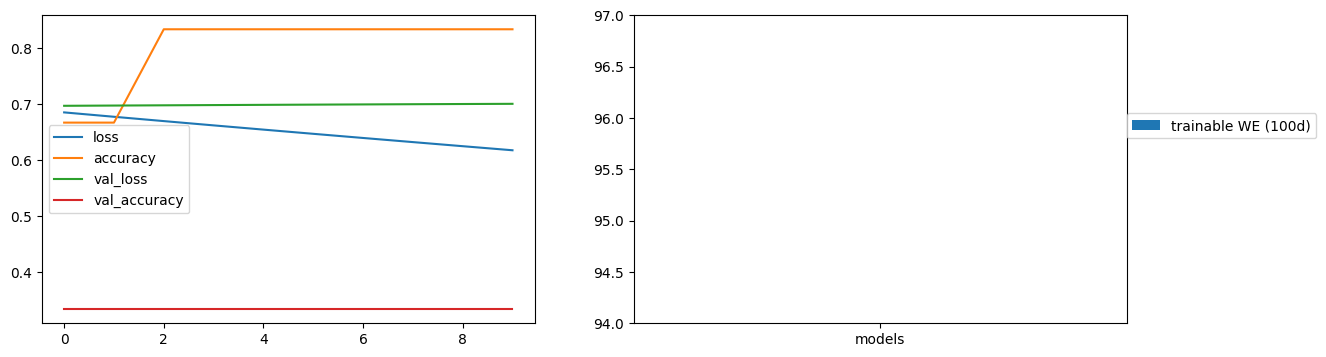

In [70]:
model = Sequential()
# the size of the vocabulary is len + 1, since 0 is also a word
model.add(Embedding(count_unique+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)) 
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

nlp = NLP_training('trainable WE (100d)', model)
nlp.fit_plot(X_train, y_train, X_test, y_test, verbose=0)

In [71]:
plot_embeded_text(model,tokenizer,X_features=X,y_results=data_file['stars'])

In [48]:
words_inorder

NameError: name 'words_inorder' is not defined

### 1.Embedding layer: trainable, tuning output dimentions

In [ ]:
for i in range(1,6):
    
    EMBEDDING_DIM = round(EMBEDDING_DIM/i)
    
    model = Sequential()
    # the size of the vocabulary is len + 1, since 0 is also a word
    model.add(Embedding(count_unique+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)) 
    model.add(Flatten())
    model.add(Dense(5,activation='softmax'))

    nlp = NLP_training(f'trainable WE ({EMBEDDING_DIM}d)', model)
    if i == 5:
        nlp.fit_plot(X_train, y_train, X_test, y_test, verbose=0)
    else:
        nlp.fit_plot(X_train, y_train, X_test, y_test, verbose=0, plot_bar=False)

### 1.Embedding layer: trainable + regularizer

In [ ]:
for i in [1e-2,1e-3,1e-4,0.0]:
    model = Sequential()
    model.add(Embedding(count_unique+1, output_dim=5,
                        input_length=MAX_SEQUENCE_LENGTH, embeddings_regularizer=regularizers.l2(i))) 
    model.add(Flatten())
    model.add(Dense(5,activation='softmax'))

    nlp = NLP_training(f'tranable WE (1d) + l2_{i}', model)
    nlp.fit_plot(X_train, y_train, X_test, y_test, verbose=0)
    if i == 0.0:
        nlp.fit_plot(X_train, y_train, X_test, y_test, verbose=0)
    else:
        nlp.fit_plot(X_train, y_train, X_test, y_test, verbose=0, plot_bar=False)

### 1.Embedding + Dense Layer

In [ ]:
model = Sequential()
model.add(Embedding(count_unique+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    embeddings_regularizer=regularizers.l2(0.1))) 
model.add(Dense(50))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

nlp = NLP_training('tranable WE (1d) + l2_0.1 + Dense(units=50)', model)
nlp.fit_plot(X_train, y_train, X_test, y_test, verbose=0)

### 2. LSTM

In [ ]:
model = Sequential()
model.add(Embedding(count_unique+1, output_dim=EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH, embeddings_regularizer=regularizers.l2(0.1))) 
model.add(LSTM(1,return_sequences=True))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

nlp = NLP_training('tranable WE (1d) + l2_0.1 + LSTM(units=1)', model)
nlp.fit_plot(X_train, y_train, X_test, y_test, verbose=0)

### 2. GRU

In [ ]:
model = Sequential()
model.add(Embedding(count_unique+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)) 
model.add(GRU(1,return_sequences=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

nlp = NLP_training('tranable WE(1d) + GRU(units=1)', model)
nlp.fit_plot(X_train, y_train, X_test, y_test, verbose=0)

In [ ]:
model = Sequential()
model.add(Embedding(count_unique+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)) 
model.add(LSTM(1,kernel_regularizer=regularizers.l2(0.001), return_sequences=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

nlp = NLP_training('tranable WE (1d) + LSTM(units=1) + l2_0.001', model)
nlp.fit_plot(X_train, y_train, X_test, y_test, verbose=0)

### 1.Embedding layer: Pre-trained: Global Vectors for Word Representation (GloVe:Wikipedia 2014 + Gigaword 5)

In [ ]:
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

In [ ]:
embedding_matrix = np.zeros((count_unique+1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model = Sequential()
model.add(Embedding(count_unique+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False, weights=[embedding_matrix])) 
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

nlp = NLP_training('GloVe WE', model)
nlp.fit_plot(X_train, y_train, X_test, y_test, verbose=0)

### 1.Embedding layer: Pre-trained: Global Vectors for Word Representation (GloVe:Twitter)

In [ ]:
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

In [ ]:
embedding_matrix = np.zeros((count_unique+1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model = Sequential()
model.add(Embedding(count_unique+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False, weights=[embedding_matrix])) 
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

nlp = NLP_training('GloVe(Twitter) WE', model)
nlp.fit_plot(X_train, y_train, X_test, y_test, verbose=0)

model = Sequential()
model.add(Embedding(count_unique+1, seq_len, input_length=seq_len)) # rescale the unique number for each token to be small decimal for nomalization; this has to be the first layer
model.add(LSTM(seq_len,return_sequences=True))
model.add(Dropout(0.5))
#model.add(LSTM(round(seq_len/5)))
#model.add(Dense(50,activation='relu'))
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit(X_train,y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=0,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop]
                   )
model.save('keras_lstm.h5')
data_history = pd.DataFrame(history.history)
data_history[['loss','val_loss']].plot()

dump(tokenizer,open('keras_lstm_tokenizer','wb'))
model = load_model('keras_lstm.h5')
tokenizer = load(open('keras_lstm_tokenizer','br'))

In [ ]:
test = ['very nice food','terrible','I didn''t waited so long for this meal', 'We waited for so long']
test_encoded = tokenizer.texts_to_sequences(test)
test_padded = pad_sequences(test_encoded, maxlen=100, padding='post')
model.predict_classes(test_padded)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

In [ ]:
X_test[0:1]

In [ ]:
print(model.predict_classes(X_test[0:2]),y_test[0:2])